In [26]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.distributions.copula.api import GaussianCopula, StudentTCopula

In [8]:
def download_data(tickers, start, end):
    data = yf.download(tickers=tickers, start = start, end = end)["Adj Close"]
    data = pd.DataFrame(
        np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns
    )
    data = data.dropna(axis=0)
    return data

In [9]:
data = download_data(tickers=["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%***********************]  6 of 6 completed


In [10]:
testmodel = arch_model(data['AAPL'], vol="Garch", p=1, o=0, q=1, dist="t", mean="Constant").fit(disp='off')

In [13]:
copulatest = GaussianCopula(k_dim=6)
copulatest = StudentTCopula(k_dim=6, df=3)

In [14]:
copulatest.fit_corr_param(data=data)

array([[1.        , 0.28863645, 0.24993552, 0.25340179, 0.4969792 ,
        0.19373797],
       [0.28863645, 1.        , 0.68277518, 0.61354629, 0.34337162,
        0.49248444],
       [0.24993552, 0.68277518, 1.        , 0.57345344, 0.31674278,
        0.42236729],
       [0.25340179, 0.61354629, 0.57345344, 1.        , 0.31976826,
        0.47923916],
       [0.4969792 , 0.34337162, 0.31674278, 0.31976826, 1.        ,
        0.26966425],
       [0.19373797, 0.49248444, 0.42236729, 0.47923916, 0.26966425,
        1.        ]])

In [15]:
copulatest.args

(array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]]),
 3)

In [16]:
copulatest.df

3

In [17]:
copulatest.rvs(10)

array([[0.02019399, 0.45999883, 0.79631426, 0.02361922, 0.97767808,
        0.99035133],
       [0.08181015, 0.90212849, 0.82569979, 0.16124822, 0.59359122,
        0.12019424],
       [0.76015649, 0.47559292, 0.78801879, 0.61414499, 0.25695076,
        0.77189264],
       [0.21902181, 0.29784777, 0.68742496, 0.96327377, 0.95836343,
        0.01214949],
       [0.08312012, 0.5518184 , 0.74958479, 0.45669494, 0.12757007,
        0.49632961],
       [0.43521735, 0.05759678, 0.22122136, 0.69790378, 0.19427152,
        0.85240363],
       [0.71878621, 0.86458442, 0.51970784, 0.64352254, 0.80755991,
        0.79125711],
       [0.38068048, 0.54895174, 0.83890198, 0.29903116, 0.41249497,
        0.15992333],
       [0.17414728, 0.79059927, 0.63078412, 0.19816589, 0.64044367,
        0.87381024],
       [0.45702018, 0.16487562, 0.19287775, 0.10685742, 0.37829685,
        0.34065068]])

In [18]:

def predict_next_period(data, VaR_level):
    garch_models = {}
    for column in data.columns:
        garch_models[column] = dict()
        am = arch_model(data[column], vol="Garch", p=1, o=0, q=1, dist="t", mean="constant").fit(disp='off')
        z = am.resid/am.conditional_volatility 
        u = am.model.distribution.cdf(z, parameters=am.params['nu'])
        garch_models[column]['arch_model'] = am
        garch_models[column]['z'] = z
        garch_models[column]['u'] = u

    u_data = pd.DataFrame()
    for ticker in data.columns:
        u_series = pd.Series(garch_models[ticker]['u'], name=ticker)
        u_data = pd.concat([u_data, u_series], axis=1)

    copula = GaussianCopula(k_dim=data.shape[1])
    copula.fit_corr_param(u_data)
    u_sim = pd.DataFrame(copula.rvs(nobs=1000), columns=data.columns)

    for ticker in garch_models.keys():
        z_sim = garch_models[ticker]['arch_model'].model.distribution.ppf(u_sim[ticker], parameters=am.params['nu'])
        garch_models[ticker]['z_sim'] = z_sim
        params = garch_models[ticker]['arch_model'].params
        sigma_next_period = np.sqrt(params['omega'] + params['alpha[1]'] * np.square(data[ticker].iloc[-1]) + params['beta[1]'] * np.square(garch_models[ticker]['arch_model']._volatility[-1]))
        next_period_returns = pd.Series(params['mu'] + sigma_next_period * garch_models[ticker]['z_sim'], name=ticker).sort_values()
        garch_models[ticker]['sigma_next_period'] = sigma_next_period
        garch_models[ticker]['next_period_returns'] = next_period_returns

    VaR = np.mean([v['next_period_returns'].quantile(VaR_level) for v in garch_models.values()])
    
    return VaR

In [19]:
result = pd.DataFrame(columns=['Portfolio', 'VaR'])

In [20]:
for i in range(data.shape[0]-1500-1):
    start = i
    end = start + 1500
    temp_data = data.iloc[start:end]
    print("start: ", start)
    print("end: ", end)
    res = predict_next_period(data=temp_data, VaR_level=0.01)
    print(res)
    result.loc[end+1, 'VaR'] = res
    result.loc[end+1, 'Portfolio'] = np.mean(data.iloc[end+1,:])

start:  0
end:  1500
-5.642544247632351
start:  1
end:  1501
-5.5382506192833665
start:  2
end:  1502
-5.921525142407357
start:  3
end:  1503
-5.519314145917712
start:  4
end:  1504
-5.351238178084558
start:  5
end:  1505
-5.922519234256048
start:  6
end:  1506
-5.5449114902939485
start:  7
end:  1507
-5.315603802328382
start:  8
end:  1508
-5.304574346245022
start:  9
end:  1509
-4.991164077980138
start:  10
end:  1510
-4.96980229218154
start:  11
end:  1511
-5.036916885557473
start:  12
end:  1512
-5.170299004903253
start:  13
end:  1513
-4.9537254434349665
start:  14
end:  1514
-4.908987534113024
start:  15
end:  1515
-4.987029607903961
start:  16
end:  1516
-5.128552302130374
start:  17
end:  1517
-4.6963618218899015
start:  18
end:  1518
-4.8454906583222686
start:  19
end:  1519
-4.746607394081248
start:  20
end:  1520
-4.603192457271567
start:  21
end:  1521
-4.808302557758693
start:  22
end:  1522
-4.387253899201679
start:  23
end:  1523
-4.765111640353444
start:  24
end:  1524


<Axes: >

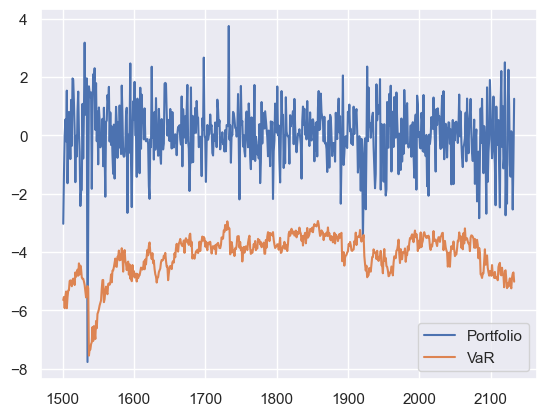

In [21]:
result.plot()

In [25]:
result.shape

(633, 2)

In [23]:
result[result['VaR']>result['Portfolio']]

,Portfolio,VaR
1535,-7.766053,-5.166912
1921,-3.597536,-3.560637


<Axes: xlabel='Portfolio', ylabel='Density'>

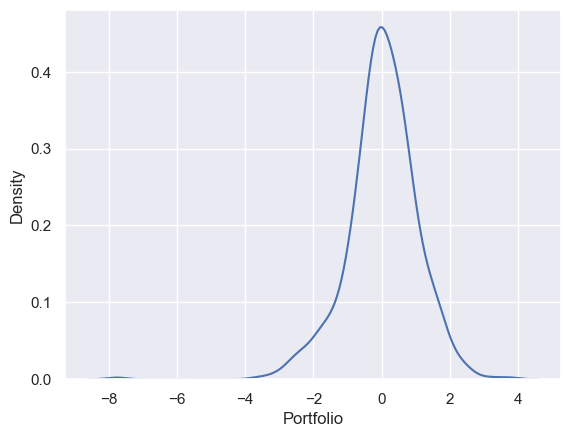

In [24]:
sns.kdeplot(result['Portfolio'])

$x_t = \mu + \sigma_t \epsilon_t\\
\sigma_t² = a_0 + a_1 x_{t-1}² + b_1 \sigma_{t-1}²$

epsilon = copula werte